In [1]:
# notebook last tested with abtem version 1.0.0beta32
%matplotlib inline

from abtem import __version__
print('current version:', __version__)

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import ase.data
import matplotlib.pyplot as plt
from scipy import constants
from abtem import *
import numpy as np

/zhome/ab/7/153983/project/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


current version: 1.0.0beta32


# HRTEM simulation of nanoparticle

We build a nanoparticle with around 16000 atoms as a Wulff construction. We add vacuum to all sides of the model and the nanoparticle is rotated to align with the <110> zone axis.

Number of atoms: 16727


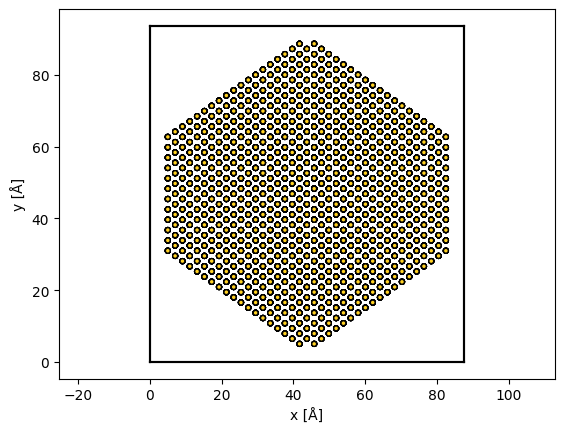

In [2]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)] # Nanoparticle facets

esurf = [1.0, 1.1, 0.9] # Relative surface energies

size = 16000 # Target number of atoms

atoms = Atoms(wulff_construction('Au', surfaces, esurf, size, 'fcc', rounding='above'))

atoms.rotate(45, 'x', center='cop')

atoms.center(vacuum=5.)

atoms.center(vacuum=2., axis=2)

show_atoms(atoms)

print("Number of atoms:", len(atoms))

Get a reasonable sampling (0.05 Å)

In [3]:
gridpoints = int(max(atoms.cell[0,0], atoms.cell[1,1]) / 0.05)
print("Grid points:", gridpoints)
# Probably wise to round to a power of two
#gridpoints = 2048
#gridpoints = 3072
gridpoints = 4096
#gridpoints = 6144


Grid points: 1873


We create the electrostatic potential. In this example, we use the infinite projection scheme to allow the notebook to run with low computational resources. The sampling used here is also a bit rough.

To simulate temperature effects set ``phonons`` to True below.  That enables *the frozen phonon method*, at a cost of a factor 30 in computer time.

The average square displacement of the atoms is calculated from the Debye temperature of the material (here gold) and the actual temperature, see: E. M. Mannebach, et al.  Nano Letters 15 (2015) 6889, suppl. online info.

$$
\left<u^2\right> = {3 \hbar^2 \over 2 m k_B \theta_D} \cdot \left(\frac14 + {T
      \over \theta_D}\right)
$$

In [4]:

phonons = True

if phonons:
    mass = ase.data.atomic_masses[ase.data.atomic_numbers['Au']]
    TD = 165  # Kittel
    T = 300
    U_squared = (3 * constants.hbar**2 / (2 *  mass * ase.units._amu * constants.k * TD)
                 * (1/4 + T / TD))
    sigmas = {'Au': np.sqrt(U_squared) * 1e10} # standard deviations of thermal vibrations
    print(sigmas)
    num_configs = 30 # number of frozen phonon configurations

    frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)
    potential = Potential(frozen_phonons, 
                          gpts=gridpoints, 
                          slice_thickness=0.5, # Changed from 0.5
                          device='gpu',
                          #storage='cpu',
                          precalculate=False,
                          parametrization='kirkland', 
                          projection='infinite')
    
else:
    potential = Potential(atoms, 
                      gpts=gridpoints, 
                      slice_thickness=0.5, 
                      device='gpu',
                      #storage='cpu',
                      parametrization='kirkland', 
                      projection='infinite')
    potential.sampling

{'Au': 0.0680474303682167}


We create the incoming plane wave and start the multislice simulation.

In [5]:
wave = Probe(sampling=potential.sampling,
    device='gpu',
    semiangle_cutoff=0.25,
    extent=potential.extent,
    defocus=0, 
    energy=30e3 # acceleration voltage in eVhttp://localhost:8080/notebooks/Kikuchi.ipynb#
)
positions = [(0, 0), (2.5, 2.5), (5, 5)] # Changed from positions = [(0, 0), (2.5, 2.5), (5, 5)] 

waves = wave.multislice(positions, potential)
exit_wave = waves


Multislice: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:02<00:00, 64.71it/s]


In [6]:
potential.sampling

(0.021367187500000002, 0.022867400964353593)

(<AxesSubplot: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fae7ff08790>)

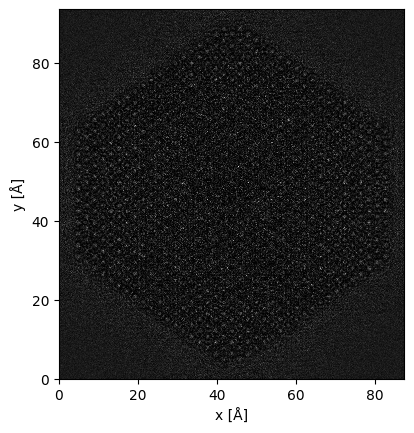

In [7]:
exit_wave[1].show()

We can get the complex exit wave function as an array. Note, when temperature effects are included, we get out a stack of exit waves by default, one for each frozen phonon configuration.

In [8]:
print(exit_wave.array.shape, exit_wave.array.dtype)

(3, 4096, 4096) complex64


In [9]:
energy = wave.energy
del potential, wave

Hack to move data back to CPU

In [10]:
if True:
    exit_wave._array = exit_wave._array.get()
    exit_wave._device = 'cpu'

We show the intensity of the first exit wave and the intensity of the thermal ensemble. To get get the intensity of the thermal ensemble, we take the mean across the ensemble dimension after calculating the intensity.

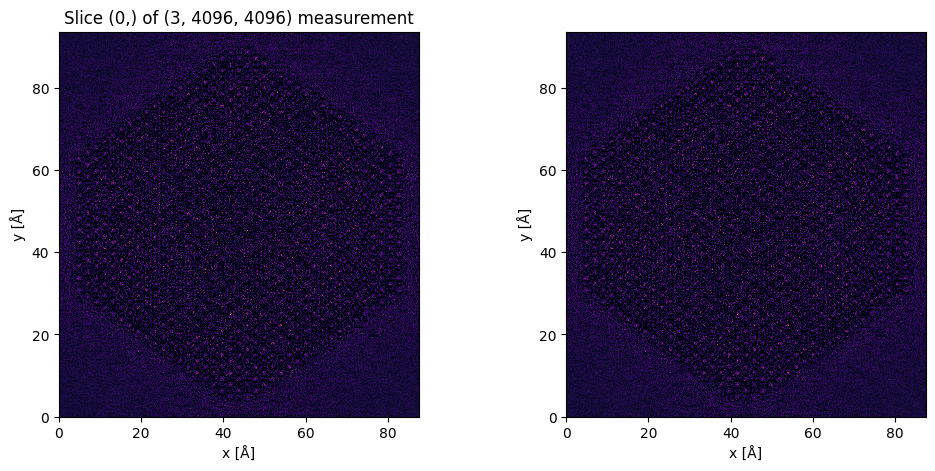

In [11]:
if phonons:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
    exit_wave.intensity().show(figsize=(6,6), ax=ax1, cmap='inferno')
    exit_wave.intensity().mean(0).show(figsize=(6,6), ax=ax2, cmap='inferno')
else:
    fig,ax1=plt.subplots(1,1,figsize=(6,6))
    exit_wave.intensity().show(ax=ax1, cmap='inferno')
# plt.savefig('test.png')

We can get the diffraction pattern up to a chosen scattering angle, we can block the zero order spot and display it on a power scale.

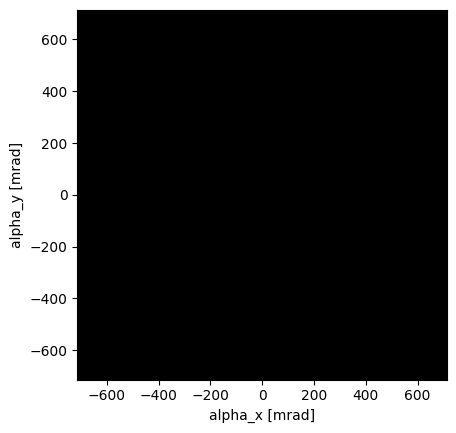

In [12]:
if phonons:
    diff = exit_wave.diffraction_pattern(max_angle='valid').mean(0)
else:
    diff = exit_wave.diffraction_pattern(max_angle='valid')
diff.show(power=.25, vmax=200)
plt.savefig("spots_phonons.png")


(<AxesSubplot: xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7fae802acaf0>)

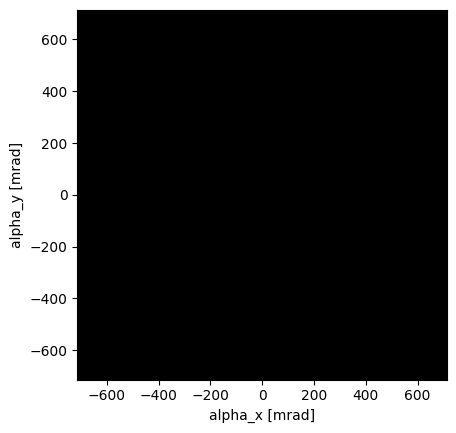

In [13]:
diff.show(vmax=5e7)

In [14]:
diff.array.max()

0.5543246

In [15]:
#f'{diff.array[1000,1000]:g}'